In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

In [3]:
PATH = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv"

In [4]:
df = pd.read_csv(PATH)
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [5]:
df.card = (df.card == "yes").astype(int)

# split df to train/val/test

In [31]:
df_full_train, df_test = train_test_split(df, random_state=1, test_size=0.2)

In [32]:
df_train, df_val = train_test_split(df_full_train, random_state=1, test_size=0.25)

In [8]:
df_train.shape, df_val.shape, df_test.shape

((791, 12), (264, 12), (264, 12))

# Q1 highest ROC AUC

In [9]:
from sklearn.metrics import roc_auc_score

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1319 entries, 0 to 1318
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   card         1319 non-null   int32  
 1   reports      1319 non-null   int64  
 2   age          1319 non-null   float64
 3   income       1319 non-null   float64
 4   share        1319 non-null   float64
 5   expenditure  1319 non-null   float64
 6   owner        1319 non-null   object 
 7   selfemp      1319 non-null   object 
 8   dependents   1319 non-null   int64  
 9   months       1319 non-null   int64  
 10  majorcards   1319 non-null   int64  
 11  active       1319 non-null   int64  
dtypes: float64(4), int32(1), int64(5), object(2)
memory usage: 118.6+ KB


In [11]:
numerical = [
    'reports',
    'age',
    'income',
    'share',
    'expenditure',
    'dependents',
    'months',
    'majorcards',
    'active'
]

In [12]:
for col in numerical:
    score = roc_auc_score(df_train.card, df_train[col])
    if score < 0.5:
        score = roc_auc_score(df_train.card, -df_train[col])
    print(f"{col}: {score:.04}")
    

reports: 0.7167
age: 0.524
income: 0.5908
share: 0.9892
expenditure: 0.991
dependents: 0.5328
months: 0.5294
majorcards: 0.5344
active: 0.6043


## best score has share column

# train the model

In [13]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [14]:
cols = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

In [15]:
def prepare_X(df, vectorizer = None):
    df = df[cols]
    row_dicts = df.to_dict(orient='records')
    if vectorizer == None:
        vectorizer = DictVectorizer(sparse=False)
        vectorizer.fit(row_dicts)
    
    return vectorizer.transform(row_dicts), vectorizer


In [16]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

# Q2 roc auc score for logistic regression

In [17]:
X, dv = prepare_X(df_train)
y = df_train.card

In [18]:
model.fit(X,y)

LogisticRegression(max_iter=1000, solver='liblinear')

In [19]:
X, _ = prepare_X(df_val, dv)
y = df_val.card
y_pred = model.predict_proba(X)[:,1]

In [20]:
roc_auc_score(y, y_pred)

0.995171242063847

# Q3 find intersection precision and recal curve

In [21]:
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt


In [22]:
thresholds = np.linspace(0,1,100)

In [23]:
precision, recall = [], []

In [24]:
for t in thresholds:
    precision.append(precision_score(y, y_pred > t))
    recall.append(recall_score(y, y_pred > t))

C:\Soft\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


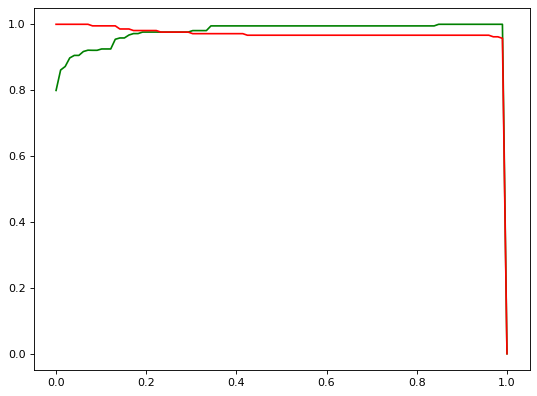

In [25]:
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(thresholds, precision, c="g")
plt.plot(thresholds, recall, c="r")


curves intersects about 0.3 threshold

# Q4 find f1_score

In [26]:
from sklearn.metrics import f1_score

In [27]:
f1_scores = {t:f1_score(y, y_pred > t) for t in thresholds}

In [28]:
sorted(f1_scores.items(), key=lambda x: x[1], reverse=True)

[(0.3434343434343435, 0.9832134292565947),
 (0.3535353535353536, 0.9832134292565947),
 (0.36363636363636365, 0.9832134292565947),
 (0.37373737373737376, 0.9832134292565947),
 (0.38383838383838387, 0.9832134292565947),
 (0.393939393939394, 0.9832134292565947),
 (0.4040404040404041, 0.9832134292565947),
 (0.4141414141414142, 0.9832134292565947),
 (0.8484848484848485, 0.983132530120482),
 (0.8585858585858587, 0.983132530120482),
 (0.8686868686868687, 0.983132530120482),
 (0.8787878787878789, 0.983132530120482),
 (0.888888888888889, 0.983132530120482),
 (0.8989898989898991, 0.983132530120482),
 (0.9090909090909092, 0.983132530120482),
 (0.9191919191919192, 0.983132530120482),
 (0.9292929292929294, 0.983132530120482),
 (0.9393939393939394, 0.983132530120482),
 (0.9494949494949496, 0.983132530120482),
 (0.9595959595959597, 0.983132530120482),
 (0.42424242424242425, 0.9807692307692307),
 (0.43434343434343436, 0.9807692307692307),
 (0.4444444444444445, 0.9807692307692307),
 (0.4545454545454546

The best f1_score if for 0.4 t (from options)

# Q5 How large is standard devidation of the AUC scores across different folds?

In [29]:
from sklearn.model_selection import KFold

In [34]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [39]:
scores = []
for train_idx, val_idx in kfold.split(df_full_train):
    train = df_full_train.iloc[train_idx]
    val = df_full_train.iloc[val_idx]
    
    X_train, dv = prepare_X(train)
    y_train = train.card
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train,y_train)
    
    X_val, _ = prepare_X(val, dv)
    y_val = val.card
    y_pred = model.predict_proba(X_val)[:,1]
    
    scores.append(roc_auc_score(y_val, y_pred))

np.std(scores)
    
    

0.0027434713804377724

How large is standard devidation of the AUC scores across different folds?  
0.003

# Q6 Which C leads to the best mean score?

In [43]:
for C in [0.01, 0.1, 1, 10]:
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        train = df_full_train.iloc[train_idx]
        val = df_full_train.iloc[val_idx]

        X_train, dv = prepare_X(train)
        y_train = train.card

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train,y_train)

        X_val, _ = prepare_X(val, dv)
        y_val = val.card
        y_pred = model.predict_proba(X_val)[:,1]

        scores.append(roc_auc_score(y_val, y_pred))

    print(f"C={C}, score={round(np.mean(scores), 3)}")

C=0.01, score=0.992
C=0.1, score=0.995
C=1, score=0.996
C=10, score=0.996


The best C is 1 (default value)